In [1]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import stable_baselines3
import time
from utils import set_size
from utils import linestyle_tuple
from utils import load_csv
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

from pde_control_gym.src.environments1d.brain_tumor_env import TherapyWrapper

In [2]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 1.1.1
Numpy version 2.2.5
Stable Baselines3 version 2.6.0


In [3]:
# Set initial condition function here
def getInitialCondition(X, nx):
    xScale = np.linspace(0, X, nx)
    c0 = 0.8 * 1e5 * np.exp(-0.25 * (xScale ** 2))
    return c0

In [4]:
# Timestep and spatial step for PDE Solver
T = 600
X = 200
dt = 1
dx = 1

In [5]:
from pde_control_gym.src import BrainTumorReward
reward_class = BrainTumorReward()

Parameters = {
  "T": T,
  "X": X,
  "dt": dt,
  "dx": dx,
  "reward_class": reward_class,
  "normalize": True,
  "D": 0.2,
  "rho": 0.03,
  "alpha": 0.04,
  "alpha_beta_ratio": 10,
  "k": 1e5,
  "t1_detection_radius": 15,
  "t1_death_radius": 35,
  "reset_init_condition_func": getInitialCondition,

  "total_dosage": 61.2 # what the action controls the use of
}


In [6]:
trainParameters = Parameters.copy()
trainParameters["verbose"] = False
env_train_base = gym.make("PDEControlGym-BrainTumor1D", **trainParameters)
env_train_wrapped = TherapyWrapper(env_train_base, verbose=False)
env_train_wrapped.benchmark()

363

In [7]:
checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logsPPO",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

model = PPO("MlpPolicy", env_train_wrapped, verbose=1, tensorboard_log="./tb/")
# Train for 500k timesteps
# model.learn(total_timesteps=5e5, callback=checkpoint_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Text(0, 0.5, 'Average Reward')

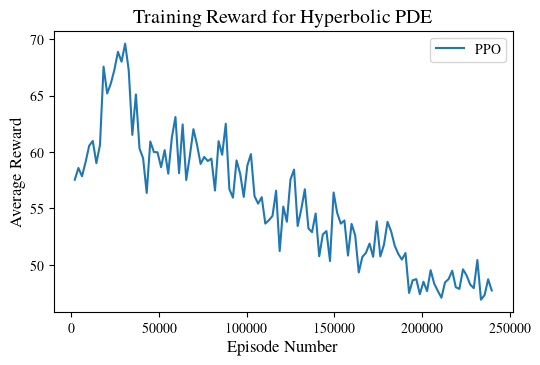

In [8]:
filenamesPPO = ["PPOData/PPO_1.csv"]

timePPOArr = []
rewardPPOArr = []
for name in filenamesPPO:
    times, rewards = load_csv(name)
    timePPOArr.append(times)
    rewardPPOArr.append(rewards)

# takes max amount of timesteps all data has
maxTimestep = np.inf
for data in timePPOArr:
    maxTimestep = min(maxTimestep, data[-1])

# remove data after minTimestep
maxDataSeqPPO = []
for data in timePPOArr:
    for i in range(len(data)):
        if data[i] >= maxTimestep:
            maxDataSeqPPO.append(i)
            break
        
# Get mean and std of each value at time step 
rewardArrCleanPPO = []
for i, data in enumerate(rewardPPOArr):
    rewardArrCleanPPO.append(data[:min(maxDataSeqPPO)])
rewardArrPPO = np.array(rewardArrCleanPPO)
meanArrPPO = rewardArrPPO.mean(axis=0)
stdArrPPO = rewardArrPPO.std(axis=0)

# Set size according to latex textwidth
fig = plt.figure(figsize=set_size(432, 0.99, (1, 1), height_add=0))
ax = fig.subplots(ncols=1)
t = timePPOArr[0]
x = t[:maxDataSeqPPO[0]]
mean = meanArrPPO
std = stdArrPPO
# 95 confidence interval
cis = (mean - 2*std, mean + 2*std)
ax.plot(x, mean, label="PPO")
ax.fill_between(x, cis[0], cis[1], alpha=0.2)

plt.legend()
plt.title("Training Reward for Hyperbolic PDE")
plt.xlabel("Episode Number")
plt.ylabel("Average Reward")

In [9]:
def runSingleEpisode(model, env, parameter):
    terminate = False
    truncate = False

    # Holds the resulting states
    uStorage = []
    rew = 0

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    while not truncate and not terminate:
        action = model(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards 

    u = np.array(uStorage)
    return rew, u


def openLoopController(_, _a):
    return 0

# hardcoded for 34 consecutive treatment days using 1.8Gy each = 61.2Gy
paper_proportions = [
      0.02941, 0.03030, 0.03125, 0.03226, 0.03333, 0.03448, 0.03571, 0.03704,
      0.03846, 0.04000, 0.04167, 0.04348, 0.04545, 0.04762, 0.05000, 0.05263,
      0.05556, 0.05882, 0.06250, 0.06667, 0.07143, 0.07692, 0.08333, 0.09091,
      0.10000, 0.11111, 0.12500, 0.14286, 0.16667, 0.20000, 0.25000, 0.33333,
      0.50000, 1.00000
    ]
constant_proportions = [
    0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8
]


def paperProportionGenerator(proportions):
    for p in proportions:
        yield p
    while True:
        yield 0

def makePaperController(proportions):
    paper_generator = paperProportionGenerator(proportions)

    def controller(_, __):
        return next(paper_generator)

    return controller


def RLController(obs, model):
    action, _state = model.predict(obs)
    return action

In [10]:
env_ol_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_ol_wrapped = TherapyWrapper(env_ol_base)
env_ol_wrapped.benchmark()

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Benchmark (episode run with no action and no reward):
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform d

363

In [11]:
rewOpenLoop, uOpenLoop = runSingleEpisode(openLoopController, env_ol_wrapped, None)
print(f"rewOpenLoop = {rewOpenLoop}")

Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_i

In [12]:
env_paper_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_paper_wrapped = TherapyWrapper(env_paper_base)
env_paper_wrapped.benchmark()

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Benchmark (episode run with no action and no reward):
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform d

363

In [13]:
rewPaper, uPaper = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped, None)
print(f"rewPaper = {rewPaper}")

Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_i

In [14]:
ppoModelPath = "./logsPPO/rl_model_240000_steps.zip"
ppoModel = PPO.load(ppoModelPath)

In [15]:
env_rl_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_rl_wrapped = TherapyWrapper(env_rl_base)
env_rl_wrapped.benchmark()

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Benchmark (episode run with no action and no reward):
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform d

363

In [16]:
rewRL, uRL = runSingleEpisode(RLController, env_rl_wrapped, ppoModel)
print(f"rewRL = {rewRL}")

Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_i

In [23]:
def plot3D(env):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(projection='3d')

    X = env.unwrapped.X
    nx = env.unwrapped.nx
    u = env.unwrapped.u
    simulation_days = env.unwrapped.simulationDays #temporal bound

    spatial = np.linspace(0, X, nx)
    temporal = np.linspace(0, simulation_days, simulation_days+1)
    data = u[:simulation_days+1, :]
    # print(spatial.shape)
    # print(temporal.shape)
    # print(data.shape)
    
    meshx, mesht = np.meshgrid(spatial, temporal)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
      axis._axinfo['axisline']['linewidth'] = 1
      axis._axinfo['axisline']['color'] = "b"
      axis._axinfo['grid']['linewidth'] = 0.2
      axis._axinfo['grid']['linestyle'] = "--"
      axis._axinfo['grid']['color'] = "#d1d1d1"
      axis.set_pane_color((1,1,1))

    ax.set_title("Evolution of Tumor Density (cells/mm³) Over Time", pad=20)
    ax.set_xlabel("x (mm)", labelpad=5)
    ax.set_ylabel("t (days)", labelpad=5)
    ax.set_zlabel("Cell density (cells / mm³)", labelpad=8)
    ax.set_box_aspect(None, zoom=0.80)

    ax.tick_params(axis='x', which='major', labelsize=8, pad=5)
    ax.tick_params(axis='y', which='major', labelsize=8, pad=2)
    ax.tick_params(axis='z', which='major', labelsize=8, pad=3)
    ax.set_xlim(0, X)
    ax.set_ylim(0, simulation_days+1)

    ax.view_init(elev=30, azim=-60)

    # plot surface
    surf = ax.plot_surface(meshx, mesht, data, edgecolor="black", lw=0.2, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    
    # plot initial condition
    # t0 = np.zeros_like(spatial)
    # vals = data[0]
    # ax.plot(spatial, t0, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

    # plot death day
    if (env.unwrapped.cDeathDay is not None):
      t_death = np.full_like(spatial, env.unwrapped.cDeathDay)
      vals = data[env.unwrapped.cDeathDay]
      ax.plot(spatial, t_death, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

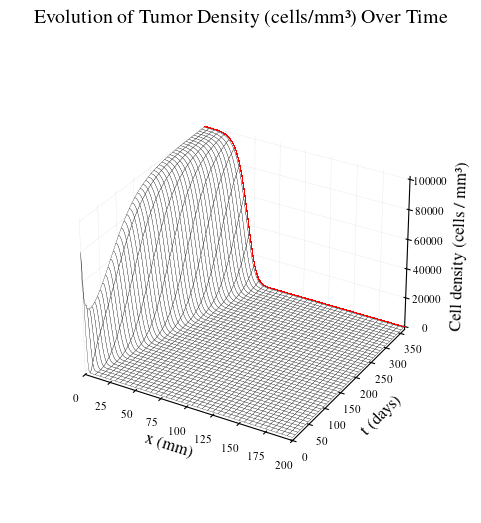

In [24]:
plot3D(env_ol_base)

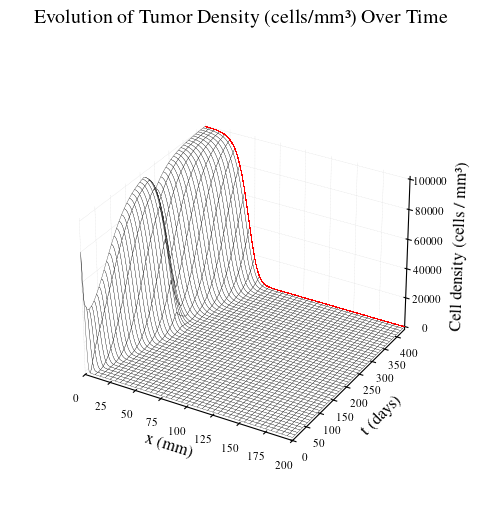

In [25]:
plot3D(env_paper_base)

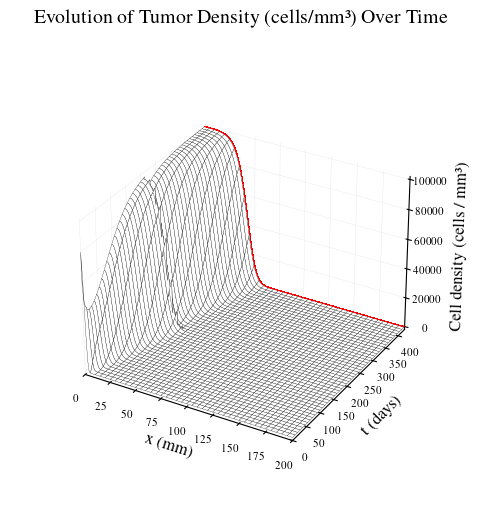

In [26]:
plot3D(env_rl_base)